# Классификация музыкальных жанров с использованием нейронных сетей

Данный проект посвящён классификации музыкальных треков по жанрам с применением методов машинного обучения. Извлекая значимые аудиохарактеристики из музыкальных файлов и обучая нейронную сеть, мы стремимся точно определять жанр заданного аудиофрагмента.

### Цели проекта
- Извлечение релевантных аудиопризнаков из музыкальных файлов
- Предварительная обработка и нормализация набора данных
- Обучение нейронной сети для многоклассовой классификации
- Оценка качества модели с использованием метрики точности и матрицы ошибок
- Предсказание жанра для новых, неизвестных аудиозаписей

## Загрузка набора данных

Набор данных содержит извлечённые аудиопризнаки из 30-секундных музыкальных фрагментов.  
Каждая строка представляет один аудиотрек, а каждый столбец соответствует определённому аудиопризнаку или метаданным.

Мы загружаем набор данных с помощью библиотеки Pandas, чтобы обеспечить удобное исследование и предварительную обработку данных.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import models, layers

In [25]:
data_path = '/Users/aror/Documents/proj/ml/features_3_sec.csv'
df = pd.read_csv(data_path)

data = df.drop(columns=['filename', 'length'])

print(f"shape: {data.shape}")
data.head() 

shape: (9990, 58)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [26]:

genre_list = data.iloc[:, -1]
print(genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: str


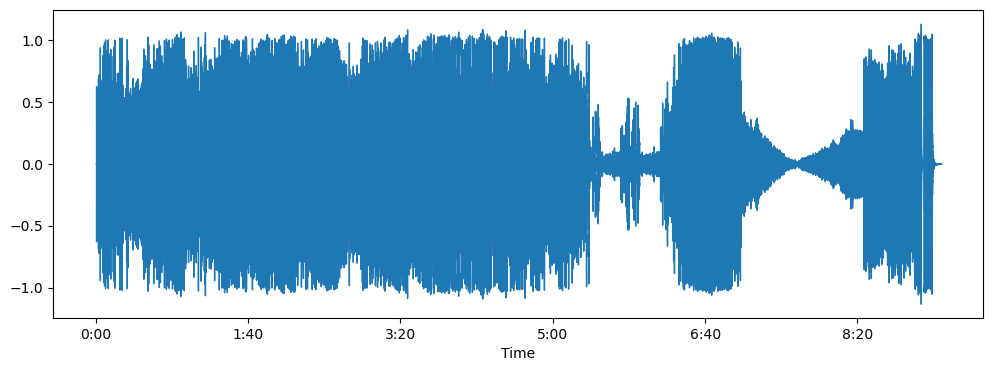

In [27]:
import matplotlib.pyplot as plt
import librosa.display as ld
file = '/Users/aror/Documents/proj/ml/Caravan.wav'

signal, sr = librosa.load(file, sr = 22050)
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr)

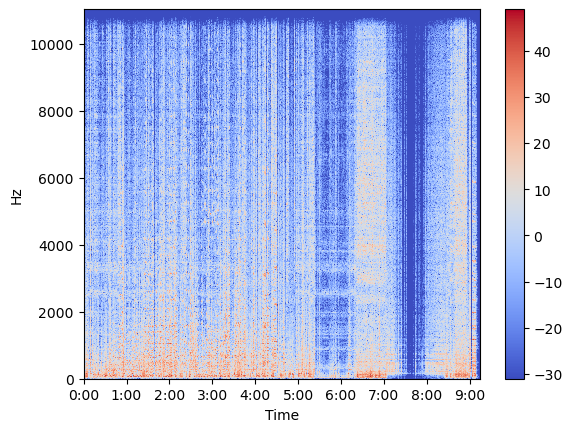

In [28]:
Xg = librosa.stft(signal)
s = librosa.amplitude_to_db(abs(Xg))
ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
plt.colorbar()

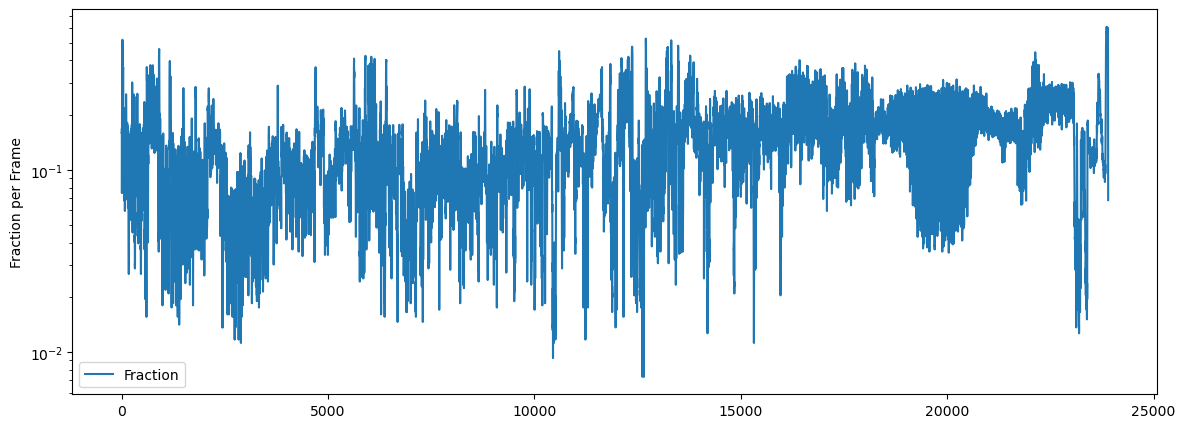

In [29]:
zrate=librosa.feature.zero_crossing_rate(signal)
plt.figure(figsize=(14,5))
plt.semilogy(zrate.T, label='Fraction')
plt.ylabel('Fraction per Frame')
plt.legend()

## Архитектура нейронной сети

Мы создаём **полносвязную нейронную сеть** со следующей структурой:

- Входной слой: вектор аудиопризнаков
- Скрытые слои с активацией ReLU для введения нелинейности
- Слои Dropout для снижения переобучения
- Выходной слой с активацией Softmax для многоклассовой классификации

Такая архитектура позволяет модели выявлять сложные нелинейные закономерности, присутствующие в аудиопризнаках музыкальных композиций.

In [30]:

model = models.Sequential([

    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)), 
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'), 
    
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary() #

/Users/aror/miniconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5490 - loss: 1.2551 - val_accuracy: 0.7092 - val_loss: 0.8438
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7060 - loss: 0.8448 - val_accuracy: 0.7598 - val_loss: 0.6869
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7584 - loss: 0.7060 - val_accuracy: 0.8018 - val_loss: 0.5849
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7967 - loss: 0.5958 - val_accuracy: 0.8278 - val_loss: 0.5168
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8211 - loss: 0.5202 - val_accuracy: 0.8398 - val_loss: 0.4692
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8350 - loss: 0.4754 - val_accuracy: 0.8519 - val_loss: 0.4357
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - loss: 0.4135 - val_accuracy: 0.8659 - val_loss: 0.3950
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3792 - val_accuracy: 0.

## Результаты обучения и валидации

Этот блок визуализирует:
- Точность на обучающей выборке против точности на валидационной выборке
- Функцию потерь на обучающей выборке против функции потерь на валидационной выборке

Эти графики помогают выявить:
- Переобучение (overfitting)
- Недообучение (underfitting)
- Стабильность процесса обучения

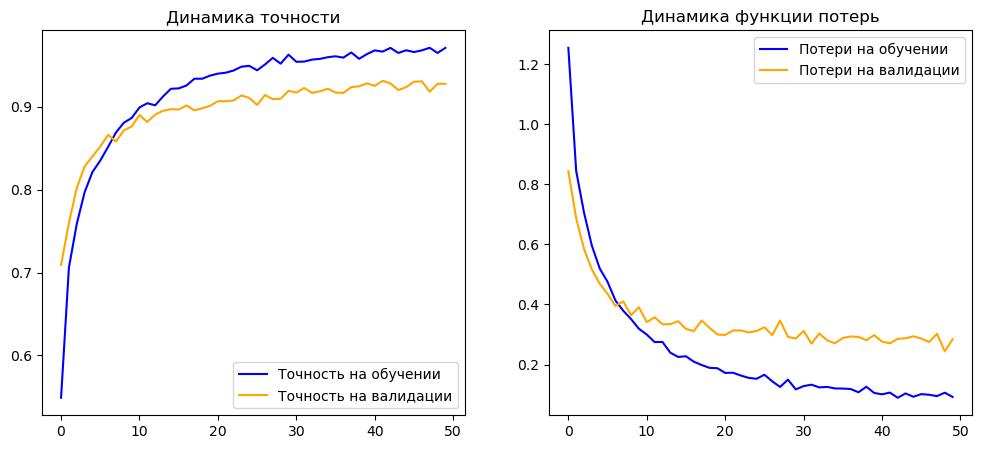

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label='Точность на валидации', color='orange')
plt.title('Динамика точности')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label='Потери на валидации', color='orange')
plt.title('Динамика функции потерь')
plt.legend()

plt.show()

## Анализ матрицы ошибок

Матрица ошибок показывает, насколько хорошо модель предсказывает каждый жанр.  
Она наглядно демонстрирует:
- Правильные классификации (диагональ матрицы)
- Ошибки классификации между похожими жанрами

Такой анализ помогает выявить, какие жанры модели наиболее сложно различать.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


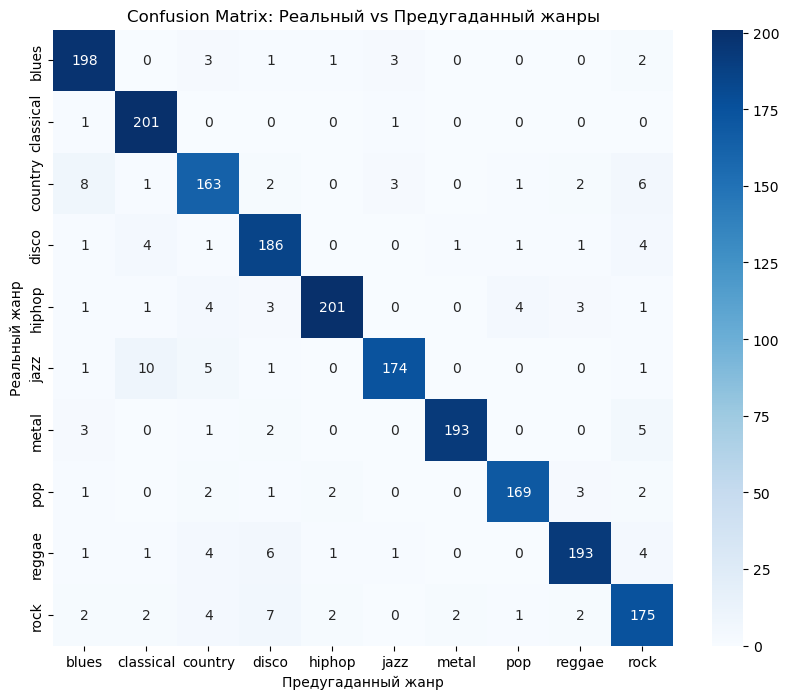

In [33]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix: Реальный vs Предугаданный жанры')
plt.xlabel('Предугаданный жанр')
plt.ylabel('Реальный жанр')
plt.show()

In [34]:
def predict_genre(audio_path):
    y, sr = librosa.load(audio_path, duration=3)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    mfcc_scaled = np.mean(mfcc.T, axis=0)

import random
random_index = random.randint(0, len(X_test)-1)
sample_to_test = X_test[random_index].reshape(1, -1)

prediction = model.predict(sample_to_test)
predicted_index = np.argmax(prediction)
actual_index = y_test[random_index]

print(f"\n--- RESULT ---")
print(f"prediction: {encoder.classes_[predicted_index]}")
print(f"actual genre: {encoder.classes_[actual_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

--- RESULT ---
prediction: hiphop
actual genre: hiphop


## Предсказание жанра для новых аудиозаписей

Данный раздел демонстрирует пошаговый процесс:
1. Загрузка нового аудиофайла
2. Извлечение тех же аудиопризнаков, которые использовались при обучении
3. Применение масштабирования признаков (нормализации)
4. Предсказание музыкального жанра с помощью обученной модели

Этот этап имитирует работу системы в реальных условиях эксплуатации.

In [35]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

def final_system_predict(file_path):
    y, sr = librosa.load(file_path, offset=10, duration=3)
    

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    features = [
        np.mean(chroma_stft).item(), np.var(chroma_stft).item(), 
        np.mean(rms).item(), np.var(rms).item(),
        np.mean(spec_cent).item(), np.var(spec_cent).item(), 
        np.mean(spec_bw).item(), np.var(spec_bw).item(),
        np.mean(rolloff).item(), np.var(rolloff).item(), 
        np.mean(zcr).item(), np.var(zcr).item()
    ]
    
    harmony, perceptr = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # float
    if isinstance(tempo, np.ndarray):
        tempo = tempo[0]

    features.extend([
        np.mean(harmony).item(), np.var(harmony).item(),
        np.mean(perceptr).item(), np.var(perceptr).item(),
        float(tempo) 
    ])
    

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for m in mfcc:
        features.append(np.mean(m).item())
        features.append(np.var(m).item())


    features_np = np.array(features, dtype=float).reshape(1, -1)
    features_scaled = scaler.transform(features_np) 

    prediction = model.predict(features_scaled, verbose=0)
    predicted_genre = encoder.classes_[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    
    print("-" * 30)
    print(f"PREDICTED GENRE: {predicted_genre.upper()}")
    print(f"CONFIDENCE: {confidence:.2f}%")
    print("-" * 30)

my_song = "/Users/aror/Documents/proj/ml/Radiohead - No Surprises.wav"
final_system_predict(my_song)

------------------------------
PREDICTED GENRE: JAZZ
CONFIDENCE: 77.62%
------------------------------
